# Análisis exploratorio de datos

In [1]:
import sqlite3
import pandas as pd
import importlib
import matplotlib.pyplot as plt
import utils
import constants
importlib.reload(utils)
importlib.reload(constants)

pd.set_option("display.max_colwidth", None)  # Muestra todo el contenido de las columnas

## Lectura de la base de datos:
La Ruta del archivo .db (podría ser una conexión con una base de datos o un datalake)

In [2]:
# Conexion
conn = sqlite3.connect(constants.DB_PATH)
cursor = conn.cursor()

# Cargue de datos en dataframes:
df_reviews = pd.read_sql_query(constants.QUERY_REVIEWS, conn)
df_products = pd.read_sql_query(constants.QUERY_PRODUCTS, conn)

# Cierre de conexión:
conn.close()

In [3]:
total_df_reviews = len(df_reviews)
total_df_products = len(df_products)

print(constants.MSJ_TAM_REVIEWS, total_df_reviews)
print(constants.MSJ_TAM_PRODUCTS, total_df_products)

Tamaño de tabla reviews: 2751400
Tamaño de tabla products: 908258


## Análisis reviews

1) Obtener cantidad de nulos en cada uno de las tablas.

In [4]:
df_null_reviews = pd.DataFrame({
    constants.COL_FIELD: df_reviews.columns,
    constants.COL_NULLS_COUNT: df_reviews.isnull().sum().values,
    constants.COL_NULLS_PERC: (df_reviews.isnull().sum().values / total_df_reviews) * 100
})

print(df_null_reviews)

               Field  Nulls_Count  Nulls_Perc
0       review_score       125084    4.546195
1              title            0    0.000000
2     review_content        44040    1.600640
3             images        44132    1.603983
4         product_id       125340    4.555499
5  parent_product_id       125340    4.555499
6        customer_id       125171    4.549357
7        review_date        43837    1.593262
8            upvotes        43947    1.597260
9  purchase_verified        43654    1.586610


2) Se eliminan datos de acuerdo a los siguientes supuestos:

* review_score: Se eliminan los valores en nulo, ya que es importante el puntaje en un sistema de recomendación, para realizar medidas de rendimiento, además que es un candidado para variable target.

* title: se elimina característica, con el supuesto de que en la reseña viene la información contenida en el título.

* review_content: es importante la reseña que da el usuario, ya que es una información valiosa para determinar el gusto o disgusto por el producto, por tanto se elimnan los registros con valores en nulo.

* images: para las primeras versiones de este proyecto no se tendrá en cuenta las fotos o imágenes que los usuarios usen en las reseñas, ya que por temas de alcance no es posible su uso, en proyectos futuros podría usarse esta variable, ya que tiene pocos nulos.

* product_id, parent_product_id: es necesario tener este valor para poder cruzarlo con la información del producto como tal. Por tanto, se eliminan los registros que no tengan este valor.

* customer_id: dependiendo del algoritmo que se quiera usar es necesario tener el usuario. Por tanto, se eliminan los registros que son nulos.

* review_date: dependiendo del algoritmo que se quiera usar, es necesario tener la fecha de la reseña. Por tanto, se eliminan los registros que son nulos.

* upvotes: Puede ser interesante para el análisis. Se eliminan los registros que tienen null en este campo.

* purchase_verified: Puede ser interesante para el análisis. Se eliminan los registros que tienen null en este campo.


NOTA: dado que el porcentaje de nulos en todos los campos es bajo y dado que se tienen muchos datos para realizar el modelo, se toman las decisiones antes mencionadas.

In [5]:
# Eliminar filas donde 'review_score' sea nulo
df_reviews = df_reviews.dropna(subset=[constants.COL_REVIEW_SCORE])

# Eliminar filas donde 'review_content' sea nulo
df_reviews = df_reviews.dropna(subset=[constants.COL_REVIEW_CONTENT])

# Eliminar la columna 'images', 'title'
df_reviews = df_reviews.drop(columns=[constants.COL_IMAGES, constants.COL_TITLE], errors=constants.OPT_IGNORE)

# Eliminar filas donde 'product_id' o 'parent_product_id' sean nulos
df_reviews = df_reviews.dropna(subset=[constants.COL_PRODUCT_ID, constants.COL_PARENT_PRODUCT_ID])

# Eliminar filas donde 'customer_id' sea nulo
df_reviews = df_reviews.dropna(subset=[constants.COL_CUSTOMER_ID])

# Eliminar filas donde 'review_date' sea nulo
df_reviews = df_reviews.dropna(subset=[constants.COL_REVIEW_DATE])

# Eliminar filas donde 'upvotes' sea nulo
df_reviews = df_reviews.dropna(subset=[constants.COL_UPVOTES])

# Eliminar filas donde 'purchase_verified' sea nulo
df_reviews = df_reviews.dropna(subset=[constants.COL_PURCHASE_VERIFIED])


## Análisis Products

1) Obtener cantidad de nulos en cada uno de las tablas.

In [13]:
df_null_products = pd.DataFrame({
    constants.COL_FIELD: df_products.columns,
    constants.COL_NULLS_COUNT: df_products.isnull().sum().values,
    constants.COL_NULLS_PERC: (df_products.isnull().sum().values / total_df_products) * 100
})

print(df_null_products)

                Field  Nulls_Count  Nulls_Perc
0       product_title            0    0.000000
1      average_rating            0    0.000000
2        rating_count            0    0.000000
3            features            0    0.000000
4         description            0    0.000000
5               price       853001   93.916156
6              images            0    0.000000
7          store_name        29526    3.250838
8          categories            0    0.000000
9             details            0    0.000000
10  parent_product_id        42735    4.705161
11    bought_together            0    0.000000


2) Se validan los valores únicos en algunas columnas:

In [6]:
val_cols = [constants.COL_BOUGHT_TOGETHER, constants.COL_CATEGORIES]
for col in val_cols:
    print(f"Unique values in '{col}': {df_products[col].unique()}")

Unique values in 'bought_together': ['null']
Unique values in 'categories': ['[]']


3) Se eliminan datos de acuerdo a los siguientes supuestos:

* price: tiene 93 % de valores nulos, por tanto se elimina esta característica.

* bought_together, categories: no tienen varianza, por tanto no sirven para el modelo. Se eliminan ambas características.


In [7]:
# Eliminar la columna 'price', 'bought_together', 'categories'
df_products = df_products.drop(columns=[constants.COL_PRICE, constants.COL_BOUGHT_TOGETHER, constants.COL_CATEGORIES], errors=constants.OPT_IGNORE).drop_duplicates(constants.COL_PARENT_PRODUCT_ID)

# - PREPARACIÓN DE DATOS PARA LOS MODELOS - 

* Dadas las restricciones de tiempo y procesamiento para la iteración 1 del proyecto, se obtiene una muestra de n = 1000 productos para el modelo, inicialmente se busca hacer recomendaciones basadas en imagenes del producto. Para evitar sesgos se busca hacer una estratificación basada en el rating promedio de los productos.

In [8]:
df_products_sampled = utils.sample_top_rated_products(df= df_products, n= constants.PRODUCTS_QTY)
print(constants.MSJ_TAM_SAMPLED, len(df_products_sampled))

Tamaño sampled: 100


<Axes: >

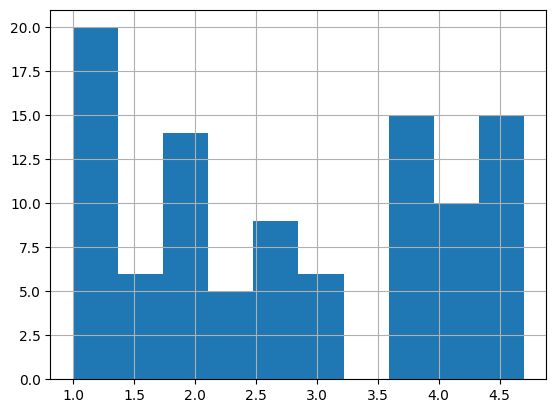

In [9]:
df_products_sampled[constants.COL_AVERAGE_RATING].hist()

Con los datos obtenidos en la muestra de 1000 productos, se obtiene solamente la primera imagen (large), la cual se descargará para realizar el modelo.

In [13]:
# Crear la nueva columna
df_products_sampled[constants.COL_IMAGE_1] = df_products_sampled[constants.COL_IMAGES].apply(utils.extract_first_large)

# descargar la imagen y guardarla en datos.
utils.download_images(df=df_products_sampled, save_path=constants.PATH_IMAGES)

Imagen guardada: B0BXGTPWK8.jpg
Imagen guardada: B09J15X7TD.jpg
Imagen guardada: B0BGZKDB2R.jpg
Imagen guardada: B0BMPQSYZ6.jpg
Imagen guardada: B08KPWYH7B.jpg
Imagen guardada: B09TXZHKLG.jpg
Imagen guardada: B012VSGNPY.jpg
Imagen guardada: B07VSGT2KB.jpg
Imagen guardada: B0BGPM4ZSG.jpg
Imagen guardada: B08945DD7K.jpg
Imagen guardada: B08ZYBS2SK.jpg
Imagen guardada: B071CJSMQ2.jpg
Imagen guardada: B07W18KVX3.jpg
Imagen guardada: B09W1JJ3FV.jpg
Imagen guardada: B097RFTKJP.jpg
Imagen guardada: B09MF2G7JX.jpg
Imagen guardada: B082XSTKMJ.jpg
Imagen guardada: B081XYDBL2.jpg
Imagen guardada: B01DQCBUJS.jpg
Imagen guardada: B08BFQ17HR.jpg
Imagen guardada: B08CR5HFC6.jpg
Imagen guardada: B01LZPE9OF.jpg
Imagen guardada: B08CD481GL.jpg
Imagen guardada: B07VT55KHJ.jpg
Imagen guardada: B08GQ1W3RT.jpg
Imagen guardada: B07T33KN4N.jpg
Imagen guardada: B0159B2TEO.jpg
Imagen guardada: B07YFSDMF4.jpg
Imagen guardada: B08HN3KWBL.jpg
Imagen guardada: B0746G6B54.jpg
Imagen guardada: B08ZYH8SJF.jpg
Imagen g

### Filtrado del dataframe de Reviews para tener en cuenta unicamente los productos que se han filtrado anteriormente:

En esta primera version, y dado las restricciones de tiempo y procesamiento, solo se tiene en cuenta las reseñas dadas para los productos que se han filtrado.

In [14]:
df_reviews_filtered = utils.filter_dataframe_by_images (image_folder=constants.PATH_IMAGES, df=df_reviews)
df_products_filtered = utils.filter_dataframe_by_images (image_folder=constants.PATH_IMAGES, df=df_products_sampled)

In [15]:
print(len(df_reviews_filtered))
print(len(df_products_filtered))

27176
83


# - Se guardan los datos para empezar a realizar el modelo -

In [16]:
df_products_filtered.to_csv(constants.PATH_DF_PRODUCTS_FILTERED, index=False)
df_reviews_filtered.to_csv(constants.PATH_DF_REVIEWS_FILTERED, index=False)